In [1]:
import os
import random
import csv
import math
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import pandas as pd

In [2]:
# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# sklearn metrics
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
# ----------------------------
# CONFIG - EDIT THESE
# ----------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [13]:
# Path to dataset root containing 'images/' and 'masks/' subfolders
# Example local: r"C:\Users\Berhanu pc\Drive\Sessile-Main-Kvasir-SEG"
# Example Colab Drive: "/content/drive/MyDrive/datasets/Sessile-Main-Kvasir-SEG"
DATA_ROOT = r"C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\sessile-main-Kvasir-SEG"  # <-- EDIT

IMAGE_DIR = os.path.join(DATA_ROOT, "images")
MASK_DIR  = os.path.join(DATA_ROOT, "masks")

OUT_DIR = os.path.join(DATA_ROOT, "outputs")
CKPT_DIR = os.path.join(OUT_DIR, "ckpts")
PRED_DIR = os.path.join(OUT_DIR, "predictions")
FIG_DIR  = os.path.join(OUT_DIR, "figures")
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(PRED_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

In [31]:
# Training hyperparams (adjust to GPU memory)
IMG_SIZE = 256        # 256 recommended; lower if memory limited
BATCH_SIZE = 8
EPOCHS = 30
LR = 1e-4
THRESH = 0.5          # binarization threshold for predictions

In [15]:
# ----------------------------
# UTIL: robust filename indexing
# ----------------------------
def index_by_stem(directory):
    d = {}
    for p in glob(os.path.join(directory, "*")):
        if os.path.isfile(p):
            stem = os.path.splitext(os.path.basename(p))[0]
            d[stem] = p
    return d


In [16]:
img_index = index_by_stem(IMAGE_DIR)
msk_index = index_by_stem(MASK_DIR)
common_stems = sorted(list(set(img_index.keys()) & set(msk_index.keys())))
if len(common_stems) == 0:
    raise FileNotFoundError(f"No matching image/mask basenames found in {IMAGE_DIR} and {MASK_DIR}")

print(f"Found {len(common_stems)} paired image-mask files (using stem intersection).")


Found 196 paired image-mask files (using stem intersection).


In [17]:
# ----------------------------
# DATA: generator helpers
# ----------------------------
def read_image(path, size=(IMG_SIZE, IMG_SIZE)):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32) / 255.0
    return img

In [18]:
def read_mask(path, size=(IMG_SIZE, IMG_SIZE)):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise FileNotFoundError(path)
    m = cv2.resize(m, size, interpolation=cv2.INTER_NEAREST)
    m = (m > 127).astype(np.float32)  # binary
    m = np.expand_dims(m, -1)
    return m

In [19]:
# Build lists of file paths (paired)
all_image_paths = [img_index[s] for s in common_stems]
all_mask_paths  = [msk_index[s] for s in common_stems]


In [20]:
# Optional: shuffle and split
pairs = list(zip(all_image_paths, all_mask_paths))
random.shuffle(pairs)
n = len(pairs)
n_train = int(0.7 * n)
n_val   = int(0.15 * n)
train_pairs = pairs[:n_train]
val_pairs   = pairs[n_train:n_train + n_val]
test_pairs  = pairs[n_train + n_val:]
print(f"Split -> train: {len(train_pairs)}, val: {len(val_pairs)}, test: {len(test_pairs)}")


Split -> train: 137, val: 29, test: 30


In [21]:
# Data generator using Python generator (keras fit accepts generators with steps_per_epoch)
def augment_pair(image, mask):
    # Simple augmentation: flips, rotate by k*90°, brightness
    if random.random() < 0.5:
        image = np.fliplr(image).copy()
        mask  = np.fliplr(mask).copy()
    if random.random() < 0.5:
        image = np.flipud(image).copy()
        mask  = np.flipud(mask).copy()
    if random.random() < 0.5:
        k = random.choice([1,2,3])
        image = np.rot90(image, k).copy()
        mask  = np.rot90(mask, k).copy()
    if random.random() < 0.4:
        # brightness
        factor = 1.0 + (random.uniform(-0.15, 0.15))
        image = np.clip(image * factor, 0, 1)
    return image, mask

In [22]:
def data_generator(pairs, batch_size=BATCH_SIZE, training=True):
    while True:
        if training:
            random.shuffle(pairs)
        for i in range(0, len(pairs), batch_size):
            batch = pairs[i:i+batch_size]
            imgs, msks = [], []
            for img_p, msk_p in batch:
                img = read_image(img_p)
                msk = read_mask(msk_p)
                if training:
                    img, msk = augment_pair(img, msk)
                imgs.append(img)
                msks.append(msk)
            yield np.array(imgs, dtype=np.float32), np.array(msks, dtype=np.float32)


In [23]:
train_gen = data_generator(train_pairs, BATCH_SIZE, training=True)
val_gen   = data_generator(val_pairs,   BATCH_SIZE, training=False)
test_gen  = data_generator(test_pairs,  BATCH_SIZE, training=False)
steps_per_epoch = math.ceil(len(train_pairs)/BATCH_SIZE)
val_steps = math.ceil(len(val_pairs)/BATCH_SIZE)


In [24]:
# ----------------------------
# MODEL: U-Net (simple, robust)
# ----------------------------
def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        return x

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    b = conv_block(p4, 512)

    # Decoder
    u4 = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(b)
    u4 = layers.Concatenate()([u4, c4])
    d4 = conv_block(u4, 256)

    u3 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(d4)
    u3 = layers.Concatenate()([u3, c3])
    d3 = conv_block(u3, 128)

    u2 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(d3)
    u2 = layers.Concatenate()([u2, c2])
    d2 = conv_block(u2, 64)

    u1 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(d2)
    u1 = layers.Concatenate()([u1, c1])
    d1 = conv_block(u1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d1)

    model = keras.Model(inputs, outputs, name="UNet")
    return model

In [25]:
# ----------------------------
# LOSS & METRICS
# ----------------------------
def dice_coeff_tf(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [26]:
def dice_loss_tf(y_true, y_pred):
    return 1.0 - dice_coeff_tf(y_true, y_pred)


In [27]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice_loss_tf(y_true, y_pred)


In [28]:
# ----------------------------
# COMPILE MODEL
# ----------------------------
model = build_unet((IMG_SIZE, IMG_SIZE, 3))
model.compile(optimizer=Adam(LR), loss=bce_dice_loss,
              metrics=[tf.keras.metrics.MeanIoU(num_classes=2), dice_coeff_tf])
model.summary()


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 256, 256, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 256, 256, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 32)      │           9,248 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256, 256, 32)      │             128 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 256, 256, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 32)      │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128, 128, 64)      │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 128, 128, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 128, 128, 64)      │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 128, 128, 64)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 64)        │               0 │ activation_3[0][0]         │
│ (MaxPooling2D)                │                           │               

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# ----------------------------
# CALLBACKS
# ----------------------------
ckpt_path = os.path.join(CKPT_DIR,"unet_best.keras")
callbacks = [
    ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_dice_coeff_tf", mode="max"),
    ReduceLROnPlateau(monitor="val_dice_coeff_tf", factor=0.5, patience=5, verbose=1, mode="max"),
    EarlyStopping(monitor="val_dice_coeff_tf", patience=12, restore_best_weights=True, mode="max")
]


In [35]:
# ----------------------------
# TRAIN
# ----------------------------
print("Starting training...")
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - dice_coeff_tf: 0.1534 - loss: 0.7282 - mean_io_u: 0.4587 - val_dice_coeff_tf: 0.1002 - val_loss: 0.7835 - val_mean_io_u: 0.4729 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - dice_coeff_tf: 0.1622 - loss: 0.6704 - mean_io_u: 0.4603 - val_dice_coeff_tf: 0.1146 - val_loss: 0.7523 - val_mean_io_u: 0.4681 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 107s 6s/step - dice_coeff_tf: 0.1715 - loss: 0.6345 - mean_io_u: 0.4581 - val_dice_coeff_tf: 0.0990 - val_loss: 0.7300 - val_mean_io_u: 0.4724 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - dice_coeff_tf: 0.1605 - loss: 0.6222 - mean_io_u: 0.4622 - val_dice_coeff_tf: 0.0854 - val_loss: 0.7234 - val_mean_io_u: 0.4768 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - dice_coeff_tf: 0.1859 - loss: 0.6028 - mean_io_u: 0.4576 - val_dice_coeff_tf: 0.1247 - val

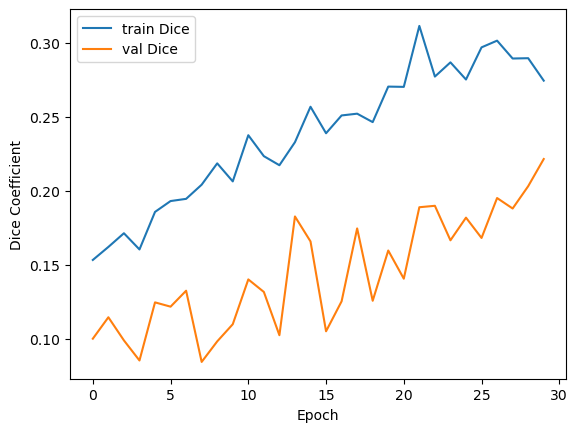

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['dice_coeff_tf'], label='train Dice')
plt.plot(history.history['val_dice_coeff_tf'], label='val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [37]:
# ----------------------------
# LOAD BEST WEIGHTS (if checkpoint saved)
# ----------------------------
if os.path.exists(ckpt_path):
    print("Loading best checkpoint:", ckpt_path)
    model = keras.models.load_model(ckpt_path, compile=False)
    # recompile to have metrics
    model.compile(optimizer=Adam(LR), loss=bce_dice_loss,
                  metrics=[tf.keras.metrics.MeanIoU(num_classes=2), dice_coeff_tf])


Loading best checkpoint: C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\sessile-main-Kvasir-SEG\outputs\ckpts\unet_best.keras


In [38]:
# ----------------------------
# PREDICTIONS ON TEST SET (save masks)
# ----------------------------
def predict_and_save(model, pairs, out_dir=PRED_DIR, threshold=THRESH):
    os.makedirs(out_dir, exist_ok=True)
    records = []
    for img_p, msk_p in tqdm(pairs, desc="Predicting"):
        img = read_image(img_p)
        msk = read_mask(msk_p)
        pred = model.predict(img[np.newaxis, ...])[0,...,0]
        pred_bin = (pred >= threshold).astype(np.uint8) * 255

        # Save predicted mask with same stem as ground-truth
        stem = os.path.splitext(os.path.basename(msk_p))[0]
        save_path = os.path.join(out_dir, stem + ".png")
        cv2.imwrite(save_path, pred_bin)

        # Compute per-image metrics (binary)
        gt_bin = (msk[...,0] >= 0.5).astype(np.uint8)
        pred_bin_simple = (pred >= threshold).astype(np.uint8)

        # Flatten arrays for metrics
        gt_flat = gt_bin.flatten()
        pr_flat = pred_bin_simple.flatten()

        # IoU (handle empty union)
        inter = np.logical_and(gt_flat, pr_flat).sum()
        union = np.logical_or(gt_flat, pr_flat).sum()
        if union == 0:
            iou = 1.0 if inter == 0 else 0.0
        else:
            iou = inter / union

        # Dice
        denom = gt_flat.sum() + pr_flat.sum()
        dice = 1.0 if denom == 0 and inter == 0 else (2 * inter) / denom if denom>0 else 0.0

        # precision, recall, f1 (handle degenerate cases)
        if pr_flat.sum() == 0 and gt_flat.sum() == 0:
            precision = 1.0
            recall = 1.0
            f1 = 1.0
        else:
            precision = precision_score(gt_flat, pr_flat, zero_division=0)
            recall = recall_score(gt_flat, pr_flat, zero_division=0)
            f1 = f1_score(gt_flat, pr_flat, zero_division=0)

        acc = (gt_flat == pr_flat).mean()

        records.append({
            "stem": stem,
            "image_path": img_p,
            "mask_path": msk_p,
            "pred_path": save_path,
            "iou": float(iou),
            "dice": float(dice),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "accuracy": float(acc)
        })
    return records

print("Running predictions on test set...")
records = predict_and_save(model, test_pairs, PRED_DIR, threshold=THRESH)

Running predictions on test set...


Predicting:   0%|                                                                               | 0/30 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Predicting:   3%|██▎                                                                    | 1/30 [00:03<01:29,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


Predicting:   7%|████▋                                                                  | 2/30 [00:03<00:47,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


Predicting:  10%|███████                                                                | 3/30 [00:04<00:33,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


Predicting:  13%|█████████▍                                                             | 4/30 [00:05<00:27,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


Predicting:  17%|███████████▊                                                           | 5/30 [00:05<00:22,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


Predicting:  20%|██████████████▏                                                        | 6/30 [00:06<00:20,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


Predicting:  23%|████████████████▌                                                      | 7/30 [00:07<00:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


Predicting:  27%|██████████████████▉                                                    | 8/30 [00:08<00:17,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


Predicting:  30%|█████████████████████▎                                                 | 9/30 [00:08<00:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


Predicting:  33%|███████████████████████▎                                              | 10/30 [00:09<00:14,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


Predicting:  37%|█████████████████████████▋                                            | 11/30 [00:10<00:13,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


Predicting:  40%|████████████████████████████                                          | 12/30 [00:10<00:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


Predicting:  43%|██████████████████████████████▎                                       | 13/30 [00:11<00:11,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


Predicting:  47%|████████████████████████████████▋                                     | 14/30 [00:12<00:11,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


Predicting:  50%|███████████████████████████████████                                   | 15/30 [00:12<00:10,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


Predicting:  53%|█████████████████████████████████████▎                                | 16/30 [00:13<00:09,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


Predicting:  57%|███████████████████████████████████████▋                              | 17/30 [00:14<00:09,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


Predicting:  60%|██████████████████████████████████████████                            | 18/30 [00:15<00:08,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


Predicting:  63%|████████████████████████████████████████████▎                         | 19/30 [00:15<00:07,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


Predicting:  67%|██████████████████████████████████████████████▋                       | 20/30 [00:16<00:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


Predicting:  70%|█████████████████████████████████████████████████                     | 21/30 [00:17<00:06,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


Predicting:  73%|███████████████████████████████████████████████████▎                  | 22/30 [00:17<00:05,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


Predicting:  77%|█████████████████████████████████████████████████████▋                | 23/30 [00:18<00:04,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


Predicting:  80%|████████████████████████████████████████████████████████              | 24/30 [00:19<00:04,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


Predicting:  83%|██████████████████████████████████████████████████████████▎           | 25/30 [00:20<00:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


Predicting:  87%|████████████████████████████████████████████████████████████▋         | 26/30 [00:20<00:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


Predicting:  90%|███████████████████████████████████████████████████████████████       | 27/30 [00:21<00:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


Predicting:  93%|█████████████████████████████████████████████████████████████████▎    | 28/30 [00:22<00:01,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


Predicting:  97%|███████████████████████████████████████████████████████████████████▋  | 29/30 [00:22<00:00,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


Predicting: 100%|██████████████████████████████████████████████████████████████████████| 30/30 [00:23<00:00,  1.28it/s]


In [39]:
# Save CSV summary
csv_path = os.path.join(OUT_DIR, "test_metrics.csv")
df = pd.DataFrame(records)
df.to_csv(csv_path, index=False)
print("Per-image metrics saved to:", csv_path)
print("Mean metrics:")
print(df[["iou","dice","precision","recall","f1","accuracy"]].mean().to_string())


Per-image metrics saved to: C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\sessile-main-Kvasir-SEG\outputs\test_metrics.csv
Mean metrics:
iou          0.249654
dice         0.348565
precision    0.398603
recall       0.433970
f1           0.348565
accuracy     0.909055


In [40]:
# ----------------------------
# Grad-CAM adapted for segmentation
# ----------------------------
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    raise RuntimeError("No Conv2D layer found in model.")

In [41]:
def gradcam_segmentation(model, img, target_layer_name=None):
    if target_layer_name is None:
        target_layer_name = find_last_conv_layer(model)
    grad_model = keras.models.Model([model.inputs], [model.get_layer(target_layer_name).output, model.output])
    img_tensor = tf.convert_to_tensor(img[np.newaxis, ...], dtype=tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, pred = grad_model(img_tensor)
        # scalar target: mean of predicted foreground probabilities
        target = tf.reduce_mean(pred)

    grads = tape.gradient(target, conv_outputs)[0]  # HxWxC
    weights = tf.reduce_mean(grads, axis=(0,1))     # C
    cam = tf.reduce_sum(tf.multiply(conv_outputs[0], weights), axis=-1)  # HxW
    cam = tf.nn.relu(cam)
    cam = cam.numpy()
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cam -= cam.min()
    if cam.max() > 0:
        cam = cam / cam.max()
    else:
        cam = np.zeros_like(cam)
    return cam  # normalized 0..1

In [42]:
# Visualize some Grad-CAM examples (best model)
print("Generating Grad-CAM visualizations...")
n_show = min(6, len(test_pairs))
sel = random.sample(test_pairs, n_show)
for img_p, msk_p in sel:
    img = read_image(img_p)
    msk = read_mask(msk_p)[...,0]
    cam = gradcam_segmentation(model, img)
    pred = model.predict(img[np.newaxis,...])[0,...,0]
    pred_bin = (pred >= THRESH).astype(np.uint8)

    # overlay
    heat = (cam * 255).astype(np.uint8)
    heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)[:,:,::-1] / 255.0
    overlay = (0.6 * img + 0.4 * heat)
    # plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.imshow(img); plt.title("Image"); plt.axis('off')
    plt.subplot(1,4,2); plt.imshow(msk, cmap='gray'); plt.title("GT mask"); plt.axis('off')
    plt.subplot(1,4,3); plt.imshow(pred, cmap='gray'); plt.title("Pred (prob)"); plt.axis('off')
    plt.subplot(1,4,4); plt.imshow(overlay); plt.title("Grad-CAM overlay"); plt.axis('off')
    stem = os.path.splitext(os.path.basename(msk_p))[0]
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"gradcam_{stem}.png"), dpi=150)
    plt.close()

print("Saved Grad-CAM figures to:", FIG_DIR)

Generating Grad-CAM visualizations...


C:\Users\Berhanu pc\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=['Tensor(shape=(1, 256, 256, 3))']
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


Saved Grad-CAM figures to: C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\sessile-main-Kvasir-SEG\outputs\figures


In [43]:
# ----------------------------
# Done
# ----------------------------
print("Pipeline finished.")
print("Outputs directory:", OUT_DIR)

Pipeline finished.
Outputs directory: C:\Users\Berhanu pc\Documents\Python Scripts\Multimodal segmentation\kvasir-sessile\sessile-main-Kvasir-SEG\outputs
